Made by Yoonsoo P. Bach

# Radiance Factor (RADF or $ I/F $) Calculation
The radiance factor is derivable from the shape model (i.e., the absolute value of the projected cross-sectional area as a function of time). The original code was written in ``IDL`` using ``POLYSHADE``, developed by one of our co-authors (Sunho Jin). Here, I will just utilize the projected area produced by that code, and show you how we found the 1-sigma models and draw the RADF figure.

We did a cross-check of the ranges of projected area values fron this ``IDL`` code with ``ParaView`` values (see ``04_cross_section`` notebook). 

## Testing Environment

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%d-%m %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-23-01 21:51:17 (KST = GMT+0900) 
0 Python     3.6.7 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.2.0 x86_64 i386 64bit
3 scipy      1.1.0
4 numpy      1.15.4
5 matplotlib 3.0.1
6 pandas     0.23.4
7 version_information 1.0.3


## 1-sigma Model Selection
As described in the appendix of the original publication, we multiplied a linear factor to the total projected area, and matched it with the observed magnitude (converted magnitude to a linear scale, since the error in magnitude is not Gaussian and thus the chi-square minimization process should not be used).

First, import and definitions:

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline as usp
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rcParams
from astropy.time import Time
from astropy import units as u

plt.style.use('default')
rcParams.update({'font.size':12})
V_SUN = -26.76
D2R = np.pi / 180

def arr(x): return np.array(x)

def linscale(x, a):
    return a * x

def iauHG(alpha, Gpar, degree=True):
    """ IAU H-G system. See ``iauHa2H0``.
    """
    if degree:
        alpha = np.deg2rad(alpha)

    def exp(x):
        return np.exp(x)

    tanp2 = np.tan(alpha / 2)  # tangent per 2 value
    term1 = Gpar * exp(-1.87 * tanp2**1.22)
    term2 = (1 - Gpar) * exp(-3.33 * tanp2**0.63)

    return term1 + term2


def iauHa2H0(Halpha, alpha, Gpar, degree=True):
    ''' Converts H(alpha) = V(1, 1, alpha) to H(0) using IAU HG model.
    Parameters
    ----------
    Halpha: float
        The reduced magnitude in mag unit.
    alpha: float
        The phase angle.
    Gpar: float
        The slope parameter. Usually 0.1 to 0.3.
    degree: bool
        Whether ``alpha`` is in degrees.
    '''
    H = Halpha + 2.5 * np.log10(iauHG(alpha=alpha, Gpar=Gpar, degree=degree))
    return H

def Ha2RADF(Halpha, area):
    ''' Converts H(alpha) = V(1, 1, alpha) to I/F (radiacne factor RADF)
    Parameters
    Halpha: float
        The reduced magnitude in mag unit.
    area: float or Quantity
        The cross sectional area at the observed epoch in square meter or given
        as a `Quantity`.
    '''
    if isinstance(area, u.Quantity):
        area = area.to(u.m^2)
        
    m_c = 5 * np.log10(1.4960e11)
    term1 = Halpha - V_SUN - m_c - 2.5 * np.log10(np.pi / area)
    RADF = 10**(-term1 / 2.5)
    return RADF

Then run the code to save a 4-column csv file, containing the two offsets, the linear factor, and the reduced chi-square statistic:

In [3]:
phot = pd.read_csv("phot_targ_4latex.csv")
phot = phot.sort_values(by="datetime_jd")

area_new = pd.read_csv("toutatis_new.csv")
dg_area = area_new.groupby(["off1", "off2"])

jd_obs = phot["datetime_jd"]
dof = len(jd_obs) - 1
dm = phot["merr_red"]
Gpar = 0.1

H0 = arr(iauHa2H0(phot["m_red"], phot["alpha"], Gpar=Gpar, degree=True))
I0 = arr(10**(- H0 / 2.5))  # Convert to linear-scale
dI0 = arr(I0 * dm * np.log(10) / 2.5)
chisqdf_path = Path(f"Chisq_Gpar_{1000*Gpar:04.0f}.csv")

if not chisqdf_path.exists():
    chisqsel = dict(off1=[], off2=[], factor=[], chisqred=[])
    for name, group in dg_area:
        off1, off2 = name
        area_orig = group["area"]
        ff = usp(group["jd"], area_orig)
        area = ff(jd_obs)
        popt, pcov = curve_fit(linscale, xdata=area, ydata=I0, 
                               sigma=dI0, absolute_sigma=True)
        chisqred = np.sum( ((I0 - linscale(area, *popt)) / dI0)**2 ) / dof
        chisqsel["off1"].append(off1)
        chisqsel["off2"].append(off2)
        chisqsel["factor"].append(*popt)
        chisqsel["chisqred"].append(chisqred)

    chisqdf = pd.DataFrame.from_dict(chisqsel)
    chisqdf = chisqdf.sort_values("chisqred")
    chisqdf.to_csv(chisqdf_path, index=False)

## Reproducing Fig 2
Then the following code will generate the 1-sigma models as well as the photometry results obtained in ``data_reduction``:

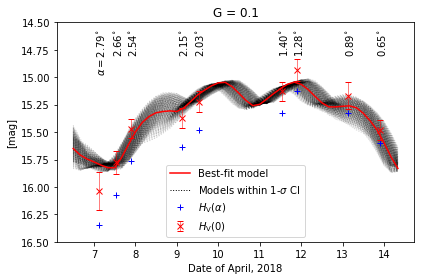

In [4]:
Ha = phot["m_red"]
jd_obs = phot["datetime_jd"]
dm = phot["merr_red"]
Ha = phot["m_red"]

area_new = pd.read_csv("toutatis_new.csv")
dg_area = area_new.groupby(["off1", "off2"])


t_ref = Time('2018-04-01', format='isot').jd - 1
dof = len(phot) - 1
t_val = arr(jd_obs - t_ref)

H0 = arr(iauHa2H0(phot["m_red"], phot["alpha"], Gpar=Gpar, degree=True))
I0 = arr(10**(-H0/2.5))  # Convert to linear-scale
dI0 = arr(I0 * dm * np.log(10) / 2.5)
chisqdf_path = Path(f"Chisq_Gpar_{1000*Gpar:04.0f}.csv")
chisqdf = pd.read_csv(chisqdf_path)

# 1-sigma models
sigma = 1
minchisq = chisqdf["chisqred"].min()
models_1sigma = chisqdf[chisqdf["chisqred"] < minchisq + sigma**2]

for i, row in models_1sigma.iterrows():
    areas = dg_area.get_group((row["off1"], row["off2"]))
    modelmag = -2.5 * np.log10(arr(row["factor"] * areas["area"]))

    xx = areas["jd"] - t_ref
    if row["chisqred"] == minchisq:
        plt.plot(xx, modelmag, 'r-', zorder=999, label="Best-fit model")
    else:
        plt.plot(xx, modelmag, 'k:', lw=1, alpha=0.1)

# Just for legend
plt.plot([None], [None], 'k:', lw=1, alpha=1, 
         label=r"Models within {:d}-$\sigma$ CI".format(sigma))

# Obseved data (reduced mag)
plt.plot(t_val, Ha, 'b+', label=r"$H_\mathrm{V}(\alpha)$")

# Calculated H-mag
plt.errorbar(t_val, H0, dm, marker='x', ls='', elinewidth=0.5, 
             capsize=3, zorder=999, color='r',
             label=r"$H_\mathrm{V}(0)$")

# Put the texts indicating phase angles
for i, a in enumerate(phot["alpha"]):
    if i == 0:
        plt.text(t_val[i]-0.1, 14.65, #H0[i] - dm[i] - 0.3, 
                 r'$\alpha = {:.2f}^{{\circ}}$'.format(a), rotation=90)
    else:
        plt.text(t_val[i]-0.1, 14.65, #H0[i] - dm[i] - 0.3, 
                 r'${:.2f}^{{\circ}}$'.format(a), rotation=90)

plt.ylim(16.5, 14.5)
plt.title(f"G = {Gpar}")
plt.legend(loc=8)
plt.ylabel(r"[mag]")
plt.xlabel("Date of April, 2018")
plt.tight_layout()

## Reproducing Fig 3
And the following code will generate the RADF plot as in the original publication:

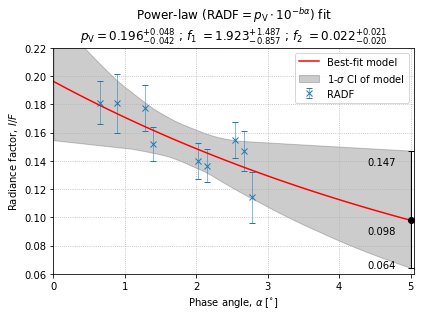

In [5]:
def powf(x, a, b):
    return a * 10**(-b * x)

def get_minmax(a, axis):
    maximum = np.max(arr(a), axis=axis)
    minimum = np.min(arr(a), axis=axis)
    return minimum, maximum


amax_sOE = 2.5
amin_sOE = 0.7
da_sOE = amax_sOE - amin_sOE

title_str = (r"Power-law ($\mathrm{{RADF}} = p_\mathrm{{V}} \cdot 10^{{-b \alpha}}$) fit"
             + "\n"
             + r"$p_\mathrm{{V}} = {:.3f}_{{-{:.3f}}}^{{+{:.3f}}}$ ; "
             + r"$ f_1 $ " 
             + r"$ = {:.3f}_{{-{:.3f}}}^{{+{:.3f}}}$ ; "
             + r"$ f_2 $ "
             + r"$ = {:.3f}_{{-{:.3f}}}^{{+{:.3f}}}$")

# The best-fit shape model
area_new = pd.read_csv("toutatis_new.csv")
dg_area = area_new.groupby(["off1", "off2"])
chisqdf = pd.read_csv(Path(f"Chisq_Gpar_0100.csv"))

bestshapemodel = dg_area.get_group((chisqdf["off1"][0], chisqdf["off2"][1]))
ff_area = usp(bestshapemodel["jd"], bestshapemodel["area"])

ksig = 1

phot = pd.read_csv("phot_targ_4latex.csv")
phot = phot.sort_values(by="datetime_jd")
alpha = phot["alpha"]
Ha = phot["m_red"]
jd_obs = phot["datetime_jd"]
dm = phot["merr_red"]
Ha = phot["m_red"]
dof = len(alpha) - 1

bestarea = ff_area(jd_obs)

RADF = Ha2RADF(Ha, bestarea)
RADF_err = RADF * np.log(10) / 2.5 * dm
popt, pcov = curve_fit(powf, alpha, RADF, sigma=RADF_err, absolute_sigma=True)
bestpV = popt[0]
bestslope = powf(0.3, *popt) / powf(5, *popt)
bestA5 = powf(5, *popt)
bestsOE = (powf(amin_sOE, *popt) - powf(amax_sOE, *popt)) / da_sOE

dpV, dpow = np.diag(np.sqrt(pcov))

aa = np.arange(0, 5.1, 0.1)

chisqredmin = np.sum(((RADF - powf(alpha, *popt)) / RADF_err)**2) / dof
pVs = np.arange(bestpV - 10 * dpV, bestpV + 10 * dpV + 0.01, 0.0025)
pows = np.arange(popt[1] - 10 * dpow, popt[1] + 10 * dpow + 0.01, 0.0025)

vals_ksig = []
slopes = []
sOEs = []
for p1 in pVs:
    for p2 in pows:
        chisqred = np.sum(((RADF - powf(alpha, p1, p2)) / RADF_err)**2) / dof
        if chisqred < (chisqredmin + ksig**2):
            slope = powf(0.3, p1, p2) / powf(5.0, p1, p2)
            sOE = (powf(amin_sOE, p1, p2) - powf(amax_sOE, p1, p2)) / da_sOE
            vals_ksig.append(powf(aa, p1, p2))
            slopes.append(slope)
            sOEs.append(sOE)

RADF_ksig_min, RADF_ksig_max = get_minmax(vals_ksig, axis=0)
sl_ksig_min, sl_ksig_max = get_minmax(slopes, axis=None)
OE_ksig_min, OE_ksig_max = get_minmax(sOEs, axis=None)
dpV_neg = bestpV - RADF_ksig_min[0]
dpV_pos = RADF_ksig_max[0] - bestpV
dA5_neg = bestA5 - RADF_ksig_min[-1]
dA5_pos = RADF_ksig_max[-1] - bestA5
dsl_neg = bestslope - sl_ksig_min
dsl_pos = sl_ksig_max - bestslope
dOE_neg = bestsOE - OE_ksig_min
dOE_pos = OE_ksig_max - bestsOE

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.set_title(title_str.format(bestpV, dpV_neg, dpV_pos, 
                              bestslope, dsl_neg, dsl_pos,
                              bestsOE, dOE_neg, dOE_pos))
ax.errorbar(alpha, RADF, RADF_err, marker='x', ls='', elinewidth=0.5, 
             capsize=3, label="RADF")
ax.fill_between(aa, RADF_ksig_min, RADF_ksig_max, color='k', alpha=0.2,
                label=r"{:d}-$\sigma$ CI of model".format(ksig))
ax.plot(aa, powf(aa, *popt), color='r', label="Best-fit model")
ax.legend()
ax.errorbar(5, bestA5, marker='o', color='k', capsize=3, elinewidth=1, 
            yerr=[[dA5_neg], [dA5_pos]])
ax.text(4.4, bestA5 - 0.01, f"{bestA5:.3f}")
ax.text(4.4, bestA5 + dA5_pos - 0.01, f"{RADF_ksig_max[-1]:.3f}")
ax.text(4.4, bestA5 - dA5_neg, f"{RADF_ksig_min[-1]:.3f}")
ax.set_xlim(0, 5.05)
ax.set_ylim(0.06, 0.22)
ax.set_xlabel(r"Phase angle, $\alpha$ $[{^{\circ}}]$")
ax.set_ylabel(r"Radiance factor, $I/F$")
ax.grid(ls=':', which='both')
plt.tight_layout()
plt.show()

A better approach might be using MC technique, but I believed the primitive brute-force grid search will suffice our goal accuracy for this work.